## Project Title: 
Predictive Modeling for Oil Sales and Store Performance(Time Series Forecasting)

## 1. Business Understanding

## Project Description

### 1. Introduction
This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.

### 1.1. Objectives
The goal of this project is to predict sales and optimize business strategies based on data provided. The data includes information on oil prices, holidays_events, store details, and sales transactions. The goal is to explore, preprocess, and develop regression models such as linear regression, XGBoost or ARIMA to predict and understand the factors influencing oil sales and store performance.

### 1.2. Methodology
To achieve the objectives, we will follow a structured approach:

Data Exploration: Thoroughly explore the provided datasets to understand the available features, their distributions, and relationships. This step will provide initial insights into the store sales data and help identify any data quality issues.

Data Preparation: Handle missing values, perform feature engineering, and encode categorical variables as necessary. This step may involve techniques like imputation, scaling, and one-hot encoding.

Time Series Analysis: Analyze the temporal aspects of the data, including trends, seasonality, and potential outliers. This analysis will provide a deeper understanding of the underlying patterns in store sales over time.

Model Selection and Training: Select appropriate time series forecasting models and train them using the prepared data. Consider incorporating external factors like promotions, holidays, and oil prices, if available, to enhance the forecasting accuracy.

Model Evaluation: Evaluate the trained models using appropriate metrics, such as mean absolute error (MAE), root mean squared error (RMSE), or mean absolute percentage error (MAPE). Assess the models' performance and identify the most accurate and reliable forecasting model.

Model Deployment and Forecasting: Deploy the chosen model to predict store sales for future time periods, leveraging the provided test dataset. Generate forecasts for the target period and assess the model's ability to capture the sales patterns accurately.

By following this methodology, we aim to provide valuable insights to the telecom company and develop a reliable predictive model for customer churn.


## Hypothesis 

### Null Hypothesis (H0): "There is no significant relationship between store sales and promotions."

### Alternative Hypothesis (Ha): "There is a significant relationship between store sales and churn promotions.

### Questions:
1. s the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)



## 2.Data Understanding

Installing libraries and Packages


In this section we will import all the packages/libraries that we will be using through this project

In [1]:
# Data Handling
import pandas as pd  # For data manipulation and analysis using DataFrames
import numpy as np  # For numerical operations and arrays
import pyodbc  # For handling connections to Microsoft SQL Server
from dotenv import dotenv_values  # For loading environment variables, possibly including database credentials
import pingouin as pg

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import scipy.stats as stats
import math  # Basic mathematical operations
from statsmodels.tsa.stattools import kpss
from scipy.stats import ttest_ind, t

# Data Visualization
import matplotlib.pyplot as plt  # For creating visualizations using Matplotlib
import seaborn as sns  # Enhanced data visualization based on Matplotlib
import plotly.express as px
import matplotlib.cm as cm


# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

# # Other Packages
import warnings  # To handle warnings in a way that they can be ignored
warnings.filterwarnings('ignore')

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("UID")
password = environment_variables.get("PWD")

# Connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [3]:
# Establish a connection
connection = pyodbc.connect(connection_string)


## Data Loading

Accessing first dataset from the database
We want to access 3 files from a remote microsoft sql server. These are the files:
1.	dbo.oil
2.	dbo.holidays_events
3.	dbo.stores

We will use the following packages:

•	pyodbc: A package for creating connection strings to the remote database

•	python-dotenv: A package for creating environment variables that will help us hide sensitve configuration informantion such as database credentials and API keys


In [4]:
# Define SQL queries to retrieve data from each table
query_oil = "SELECT * FROM dbo.oil"
query_holidays_events = "SELECT * FROM dbo.holidays_events"
query_stores = "SELECT * FROM dbo.stores"

# Retrieve data from each table
oil_data = pd.read_sql(query_oil, connection)
holidays_events_data = pd.read_sql(query_holidays_events, connection)
stores_data = pd.read_sql(query_stores, connection)

### Accessing second  dataset from the oneDdrive
We want to access 2 files from a oneDrive CSV files. These are the files:
1.	sample_submission.csv
2.	test.csv


In [5]:
# Read CSV file for submission data into DataFrames
sample_submission_data = pd.read_csv('sample_submission.csv')
sample_submission_data .head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [6]:
# Read CSV files for test data into DataFrames
test_data = pd.read_csv('test.csv')
test_data .head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### Accessing third  dataset from the GitHub


In [31]:
# Read CSV file for train data into DataFrames
train_data = pd.read_csv('train.csv')
train_data .head()

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [7]:
# Read CSV file for transactions data into DataFrames
transactions_data = pd.read_csv('transactions.csv')
transactions_data .head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Exploratory Data Analysis (EDA)


In [8]:
# View the data for oil
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [9]:
#checking the shape for oil dataframe
oil_data.shape

(1218, 2)

In [10]:
#checking for the missing values using isnull
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [11]:
#impute missing values using mean imputation
oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(oil_data['dcoilwtico'].mean())
# Check again for missing values
oil_data['dcoilwtico'].isnull().sum()

0

In [12]:
# statistics for numerical columns
oil_data.describe()

,dcoilwtico
count,1218.000000
mean,67.714366
std,25.173606
min,26.190001
25%,46.700001
50%,53.925001
75%,95.332499
max,110.620003


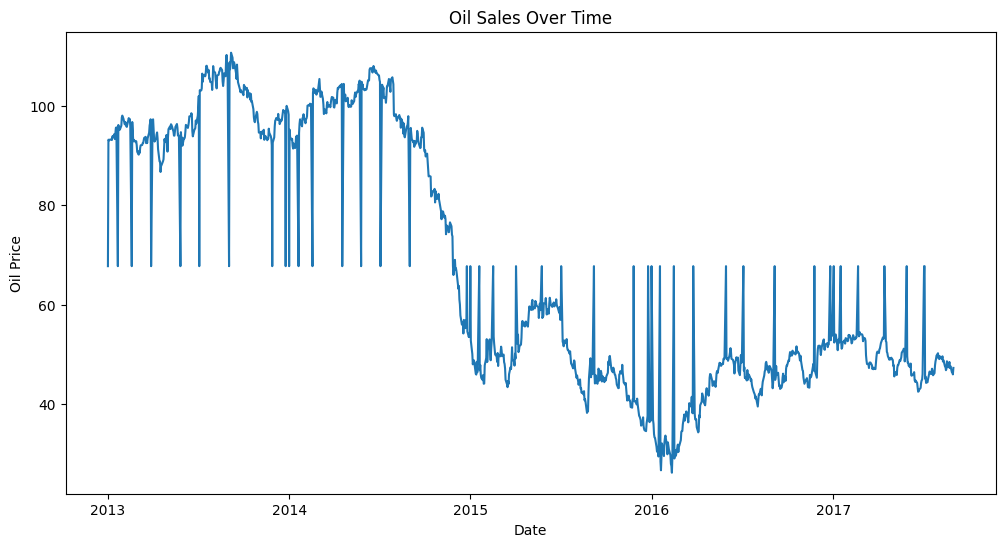

In [13]:
# Convert 'date' column to datetime format
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Extract year from 'date' column
oil_data['year'] = oil_data['date'].dt.year

# Group data by year and calculate mean oil price for each year
yearly_oil_prices = oil_data.groupby('year')['dcoilwtico'].mean().reset_index()

# Visualize the distribution of oil prices
plt.figure(figsize=(12, 6))
plt.plot(oil_data['date'], oil_data['dcoilwtico'])
plt.title('Oil Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

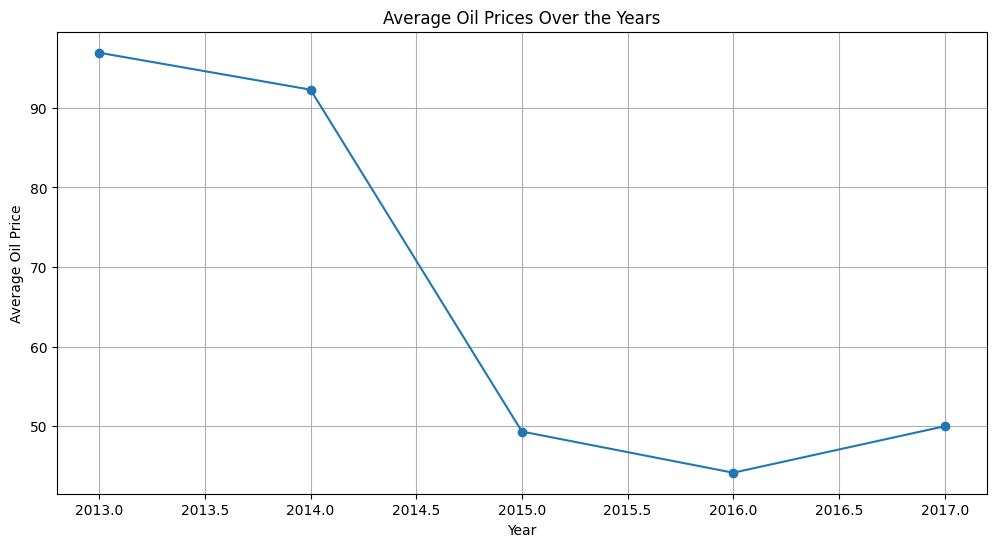

In [14]:
# Visualize the distribution of oil prices over the years
plt.figure(figsize=(12, 6))
plt.plot(yearly_oil_prices['year'], yearly_oil_prices['dcoilwtico'], marker='o')
plt.title('Average Oil Prices Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Oil Price')
plt.grid(True)
plt.show()


In [15]:
# View data for Holiday
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [16]:
#checking the shape for the holiday dataset
holidays_events_data.shape


(350, 6)

In [17]:
#checking for the missing values using isnull
holidays_events_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [18]:
# Check unique values in the 'type' column
print(holidays_events_data['type'].value_counts())

# Check unique values in the 'locale' column
print(holidays_events_data['locale'].value_counts())

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64
locale
National    174
Local       152
Regional     24
Name: count, dtype: int64


In [19]:
# statistics for numerical columns
holidays_events_data.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [20]:
#view dataset for stores
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [21]:
# checking the shape for store data
stores_data.shape

(54, 5)

In [22]:
#checking for the missing values using isnull
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [23]:
# statistics for numerical columns
stores_data.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [24]:
# view dataset for sample_submission
sample_submission_data.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [25]:
# Checking the shape for the sample_submission
sample_submission_data.shape

(28512, 2)

In [26]:
# view dataset for test
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [27]:
# cheking the shape for test dataframe
test_data.shape

(28512, 5)

In [28]:
#checking for the missing values using isnull
test_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [29]:
# statistics for numerical columns
test_data.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [30]:
# view train data 
train_data .head()

NameError: name 'train_data' is not defined

In [ ]:
# checking for the shape 
train_data.shape

In [ ]:
#checking for the missing values using isnull
train_data.isnull().sum()

In [ ]:
# statistics for numerical columns
train_data.describe()

### Transforming the 'date' column to datetime format

In [ ]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train_data['date'] = pd.to_datetime(train_data['date'])

# Test dataset
test_data['date'] = pd.to_datetime(test_data['date'])

# Holiday Events dataset
holidays_events_data['date'] = pd.to_datetime(holidays_events_data['date'])

# Oil dataset
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Transactions dataset
transactions_data['date'] = pd.to_datetime(transactions_data['date'])

In [ ]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", train_data['date'].dtype)
print("Test dataset:", test_data['date'].dtype)
print("Holiday Events dataset:", holidays_events_data['date'].dtype)
print("Oil dataset:", oil_data['date'].dtype)
print("Transactions dataset:", transactions_data['date'].dtype)

 ### Checking for the completeness of the 'date' column in the Train Dataset

In [ ]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

In [ ]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_data = pd.concat([train_data, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_data.sort_values('date', inplace=True)

In [ ]:
# Check the completeness of the train dataset
min_date = train_data['date'].min()
max_date = train_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_data['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

In [ ]:
# Veiwing the transactions dataset
transactions_data.head()

In [ ]:
# checking the shape
transactions_data.shape

In [ ]:
#checking for the missing values using isnull
transactions_data.isnull().sum()

In [ ]:
# statistics for numerical columns
transactions_data.describe()

In [ ]:
# Convert 'date' column to datetime format
transactions_data['date'] = pd.to_datetime(transactions_data['date'])

# Group data by date and calculate total transactions for each date
daily_total_transactions = transactions_data.groupby('date')['transactions'].sum().reset_index()

# Visualize the distribution of total transactions over time
plt.figure(figsize=(10, 6))
plt.plot(daily_total_transactions['date'], daily_total_transactions['transactions'], marker='o')
plt.title('Total Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.grid(True)
plt.show()



In [ ]:
# Convert 'date' column to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Create 'year' column
train_data['year'] = train_data['date'].dt.year

# Group data by year and find the index of the row with maximum sales for each year
max_sales = train_data.groupby('year')['sales'].idxmax()

# Select rows with maximum sales for each year
Result_max = train_data.loc[max_sales]

# Print the resulting DataFrame
Result_max


In [ ]:
# Horizontal bar chart of dates with highest sales each year

sns.barplot(data=Result_max, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("Highest sales date in each year")
plt.show()

## Analytical Questions

### 1. Is the train dataset complete (has all the required dates)?

In [ ]:
# Check for missing values
if train_data.isnull().values.any():
  print("The dataset is not complete. There are missing values.")
else:
  print("The dataset is complete.")

In [ ]:
# Missing dates

missing_dates = expected_dates.difference(train_data['date'].unique())
missing_dates

### 2. Which dates have the lowest and highest sales for each year?

In [ ]:
# Highest sales date in each year

train_data['year'] = train_data['date'].dt.year
max_sales = train_data.groupby('year')['sales'].idxmax()
Result_max = train_data.loc[max_sales]
Result_max

In [ ]:
# Horizontal bar chart of dates with highest sales each year

sns.barplot(data=Result_max, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("Highest sales date in each year")
plt.show()

- 2016(11/12) has the highest number of sales

In [ ]:
# lowest sales date in each year

min_sales = train_data.groupby('year')['sales'].idxmin()
Result_min = train_data.loc[min_sales]
Result_min

In [ ]:
# Horizontal bar chart of dates with lowest sales each year

sns.barplot(data=Result_min, y="date", x="sales", palette='crest')
plt.ylabel("Date")
plt.xlabel("Total sales")
plt.title("lowest sales date in each year")
plt.show()

### 3. Did the earthquake impact sales?

In [ ]:
# Set the 'date' column as the index

train_data.set_index('date', inplace=True)

# Resample to weekly frequency, aggregating with mean

sales_daily_mean = train_data["sales"].resample('D').mean()
sales_weekly_mean = train_data["sales"].resample('W').mean()


In [ ]:
# Sales for April to May 2016.
start, end = '2016-04', '2016-05'

# Analyse before and after the earthquake

fig, ax = plt.subplots(figsize=(12,6))

color_daily = 'blue'
color_weekly = 'green'

ax.plot(sales_daily_mean.loc[start:end], marker='.', linestyle='-', linewidth=0.5, label='Daily', color=color_daily)
ax.plot(sales_weekly_mean.loc[start:end], marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample', color=color_weekly)
ax.set_ylabel("Total sales")
ax.set_xlabel("Date")
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title("April and May 2016 total sales")

### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

In [ ]:
# Merge train and stores datasets

train_stores = pd.merge(train_data, stores_data)

train_stores.head()

### Store sales by cluster

In [ ]:
# Sum of sales by cluster

sales_clusters = train_stores.groupby("cluster", as_index=False)["sales"].sum()
sales_clusters

In [ ]:
# vertical Bar chart of sales by cluster

ax = sns.barplot(data=sales_clusters, x = "cluster", y = "sales", palette='viridis')
plt.xlabel("Stores by cluster")
plt.ylabel("Total sales")
plt.title("Sales of different Stores by cluster")
plt.show()

- cluster 14 has the highest sales. cluster 16 has the lowest sales.

### Store sales by city

In [ ]:
# Sum of sales by city

sales_city = train_stores.groupby("city", as_index=False)["sales"].sum()
sales_city

In [ ]:
# horizontal Bar chart of sales by city

sns.barplot(data=sales_city, y = "city", x = "sales", palette='viridis')
plt.ylabel("City of  of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by City")
plt.show()

- Quito has the highest total sales, as it is the capital, and Puyo the lowest

### Store sales by state

In [ ]:
# Sum of sales by state

sales_state = train_stores.groupby("state", as_index=False)["sales"].sum()
sales_state

In [ ]:
# horizontal Bar chart of sales by state

sns.barplot(data=sales_state, y = "state", x = "sales", palette='viridis')
plt.ylabel("States of stores")
plt.xlabel("Total sales")
plt.title("Sales of different Stores by State")
plt.show()

### Store sales by type

In [ ]:
# Sum of sales by store type

sales_type = train_stores.groupby("type", as_index=False)["sales"].sum()
sales_type

In [ ]:
# vertical Bar chart of sales by store type

sns.barplot(data=sales_type, x = "type", y = "sales", palette='viridis')
plt.xlabel("Stores by store type")
plt.ylabel("Total sales")
plt.title("Sales of Stores by type")
plt.show()

### 5. Are sales affected by promotions, oil prices and holidays?

In [ ]:
# check unique values product family

train_data['family'].unique()

In [ ]:
# Filter rows with promotions and sum sales for top 10 families
promotions = train_data[train_data["onpromotion"] != 0].groupby("family")["sales"].sum().sort_values(ascending=False).head(10)

# Filter rows without promotions and sum sales for top 10 families
no_promotions = train_data[train_data["onpromotion"] == 0].groupby("family")["sales"].sum().sort_values(ascending=False).head(10)

In [ ]:
# Create stacked bar chart to visualize sales on and off promotions

ax = promotions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
no_promotions.plot(kind='bar', stacked=True, ax=ax, colormap='cividis')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add legend
plt.legend(["Promotions", "No Promotions"])

# Label the axes and title
plt.ylabel("Sales")
plt.xlabel("Products")
plt.title("Sales of products with or without promotion (Top 10)")

plt.tight_layout()
plt.show()

### Sales and oil prices

In [ ]:
# merge train and oil dataset

merge = train_data.merge(
    oil_data, 
    how='left', 
    on=['date'])
    
merge.reset_index()
merge.head()

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot the average sales by year 
merge.groupby(['year_y'])['sales'].sum().plot.bar(ax=ax1, title='Total Sales by Year')
ax1.set_xlabel('year_y')
ax1.set_ylabel('Total Sales')

# Plot the oil data overtime
sns.lineplot(data=merge, x='date', y='dcoilwtico', ax=ax2)
ax2.set_title('Oil price overtime')
ax2.set_xlabel('year_y')
ax2.set_ylabel('oil price')

plt.tight_layout()
plt.show()

In [ ]:
# Determine the correlation between sales and oil prices

correlation = merge['sales'].corr(merge['dcoilwtico'])
print(correlation)

### Sales and holidays

In [ ]:
# merge train and holidays dataset

merge_2 = train_data.merge(
    holidays_events_data, 
    how='left', 
    on=['date'])
    
merge_2.reset_index()
merge_2.head()

In [ ]:
# Group the data by holiday type and calculate the average sales for each type
avg_sales_by_type = merge_2.groupby("type").agg({"sales": "mean"})

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plot a bar chart of the average sales by holiday type
avg_sales_by_type.plot(kind="bar", y="sales", ax=ax, legend=False)

# Add labels to the bars
for index, value in enumerate(avg_sales_by_type["sales"]):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom', fontsize=12)

# Add a title and labels
ax.set_title("Average Sales by Holiday Type", fontsize=16)
ax.set_xlabel("Holiday Type", fontsize=14)
ax.set_ylabel("Average Sales", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 6. What analysis can we get from the date and its extractable features?

In [ ]:
# Function to extract features from date column

def getDateFeatures(df, date):
    df['date'] = pd.to_datetime(df[date])
    df['month'] = df['date'].dt.month
    df['Month'] = df['date'].dt.month_name()
    df['Day'] = df['date'].dt.day_name()
    df['day_of_month'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['year'] = df['date'].dt.year
    df["is_weekend"] = np.where(df['day_of_week'] > 4, 1, 0)
    df['quarter'] = df['date'].dt.quarter
    return df

In [ ]:
# run our train data through our function

train_copy = train_data.reset_index()
train_data = getDateFeatures(train_copy, "date")
train_data.head()

### Sales on Pay Day (Semi-Monthly)

In [ ]:
# list with semi monthly pay day range (15th and last day 30/31st of the month)

pay_day = pd.date_range(start=train_data.date.min(), end=train_data.date.max(), freq='SM').astype('str').tolist()

In [ ]:
# create payday column

train_data["pay_day"] = np.where(train_data["date"].isin(pay_day), 1, 0)
train_data['pay_day'].value_counts()

In [ ]:
# Plot the average sales in relation to payday

ax = train_data.groupby(["pay_day"], as_index=False)['sales'].mean()\
                                    .plot("pay_day", "sales", kind="bar", figsize=(12,6),
                                         title="Average sales in relation to payday")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

### Sales by day of the month

In [ ]:
# plot the sum of sales by day of the month
# which day of the month has the most sales?

ax = train_data.groupby(["day_of_month"], as_index=False)["sales"].sum()\
                                    .plot("day_of_month", "sales", kind="bar", figsize=(12,6),
                                         title="Total sales by day of month")

### Sales by week of the year

In [ ]:
# plot the sum of sales by the weeks of the year

sales_by_week = train_data.groupby(["week_of_year"], as_index=False)['sales'].sum()

ax = sales_by_week.plot("week_of_year", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the weeks of the year")

### sales by month

In [ ]:
# group the sum of sales by month of the year
# which month has the highest sales?

purchase_month = train_data.groupby("Month", as_index=False)["sales"].sum().sort_values(by="sales", ascending=False)
purchase_month = purchase_month.reset_index(drop=True)
purchase_month

In [ ]:
# plot the sum of sales by month of the year

ax = purchase_month.plot("Month", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the months of the year")

### Sales by Day of the week

In [ ]:
# group the sum of sales by day of the week
# which day has the highest sales?

purchase_day = train_data.groupby("Day", as_index=False)["sales"].sum().sort_values(by="sales", ascending=False)
purchase_day = purchase_day.reset_index(drop=True)
purchase_day

In [ ]:
# plot the sum of sales by day of the week

ax = purchase_day.plot("Day", "sales", kind="bar", figsize=(12, 6),
                         title="Total sales over the days of the week")

### Sales by season

In [ ]:
# create column for rainy and dry season

train_data["season"] = np.where(train_data["month"].isin([6,7,8,9]), 1, 0)

# plot sum of sales by season of the year (Dry or Rainy)
sales_by_season = train_data.groupby(["season"], as_index=False)['sales'].sum()

ax = sales_by_season.plot("season", "sales", kind="bar", figsize=(12, 6),
                          title="Total sales over seasons in Ecuador (Dry=0, Rainy=1)")

### Sales by quarter

In [ ]:
# plot the sum of sales by quarter of the year

sales_by_quarter = train_data.groupby(["quarter"], as_index=False)['sales'].sum()

ax = sales_by_quarter.plot("quarter", "sales", kind="bar", figsize=(12, 6),
                          title="Total sales by quarter")

### 7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

i. Root Mean Squared Logarithmic Error (RMSLE)
- RMSLE is a logarithmic version of RMSE. It measures the ratio between the true and predicted values, rather than the difference.
- It's useful when the target variable has a wide range of values and you want to penalize underpredictions more than overpredictions.
- RMSLE is calculated as the square root of the mean of the squared differences between the natural logarithm of the predicted and true values.

ii. Root Mean Squared Error (RMSE)
- RMSE measures the average magnitude of the errors between predicted and true values, with errors squared to account for both underpredictions and overpredictions.
- It's commonly used and interpretable in the same units as the target variable.
- RMSE is calculated as the square root of the mean of the squared differences between predicted and true values.

iii. Mean Squared Error (MSE)
- MSE is similar to RMSE but without taking the square root. It's the average of the squared differences between predicted and true values.
- It's used to measure the average squared deviation between predicted and true values.

iv. Mean Absolute Error (MAE)
- MAE measures the average absolute differences between predicted and true values.
- It's less sensitive to outliers compared to RMSE because it doesn't square the errors.
- MAE is calculated as the mean of the absolute differences between predicted and true values.

##### Why MAE might be greater than the others
- MAE could be greater than RMSE, RMSLE, or MSE in certain cases, particularly when the errors between predicted and true values are spread out and not concentrated around zero. This can happen when there are outliers or when the distribution of errors is skewed.

## Hypothesis

- Null Hypothesis (H0): "There is no significant relationship between store sales and promotions."

- Alternative Hypothesis (H1): "There is a significant relationship between store sales and churn promotions.

In [ ]:
# encode categorical features

train_data['onpromotion_encoded'] = np.where(train_data['onpromotion'] >= 1, 1, 0)
train_data['onpromotion_encoded'].value_counts()

In [ ]:

# Extract the sales of products when they are on promotion and when they are not
sales_on_promotion = train_data[train_data['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = train_data[train_data['onpromotion_encoded'] == 0]['sales']

# Calculate the sample sizes
n1 = len(sales_on_promotion)
n2 = len(sales_not_on_promotion)

# Calculate the degrees of freedom
degrees_of_freedom = n1 + n2 - 2  # Assuming equal variances, subtract 2 for two samples

# Set the significance level
alpha = 0.05

# Calculate the critical t-values for a two-tailed test
critical_t_value = t.ppf(1 - alpha / 2, degrees_of_freedom)

# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(sales_on_promotion, sales_not_on_promotion)

# Print the t-statistic, p-value, degrees of freedom, and critical t-values
print("t-statistic:", t_stat)
print("p-value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)
print(f"Critical t-value (α = {alpha/2}):", -critical_t_value)  # Left tail
print(f"Critical t-value (α = {alpha/2}):", critical_t_value)   # Right tail

# Check if the absolute t-statistic falls within the critical value range
if t_stat >= -critical_t_value and t_stat <= critical_t_value:
    print("\nThe absolute t-statistic falls within the critical value range.")
else:
    print("\nThe absolute t-statistic does not fall within the critical value range.")

### Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Dataset

In [ ]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_data with stores_df based on 'store_nbr' column
merged_df1 = train_data.merge(stores_data, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(transactions_data, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(holidays_events_data, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_data = merged_df3.merge(oil_data, on='date', how='inner')

# View the first five rows of the merged dataset
merged_data.head()

we use of an inner merge in this time series forecasting project for corporation Favorita helps us ensure data consistency, avoid missing values, and focus on the relevant data for accurate predictions.


In [ ]:
# Check the shape of the merged dataset
merged_data.shape

In [ ]:
# Check the column information of the merged dataset
merged_data.info()

In [ ]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_data['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_data['type_y'].unique())

In [ ]:
merged_data.columns

In [ ]:
# Renaming the columns with the approapriate names
merged_train_data = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_train_data.head()

In [ ]:
# Generate summary statistics and transpose the rows and columns of the resultant DataFrame.
# Transposing flips the DataFrame (the rows become columns and the columns become rows) for better readability
merged_train_data.describe().T

### Checking for Missing Values for the merged Datasets

In [ ]:
# Check for missing values in the merged datasets
missing_values = merged_train_data.isnull().sum()
missing_values

### Checking for Duplicate Values in the Merged Datasets

In [ ]:
# Check for duplicate values in the merged dataset
duplicate_rows_merged = merged_train_data.duplicated()
duplicate_rows_merged.sum()

### Save the merged dataset in a new CSV file to be used in PowerBI Visualization

In [ ]:
merged_data.to_csv('Visualization_Data.csv', index=False)

## Univariate, Multivariate and Bivariate Analysis

### i. Univariate Analysis

#### a. Distribution of the 'sales' variable:

In [ ]:
 #Histogram
plt.hist(merged_train_data['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(merged_train_data['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

#### b. distribution of the 'transactions' variable:

In [ ]:
# Histogram
plt.hist(merged_train_data['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show()


#### c. Distribution of the 'Daily Oil Price' variable:

In [ ]:
# Histogram
plt.hist(merged_train_data['dcoilwtico'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

### ii. Bivariate Analysis

#### a. Trend of sales over time.

In [ ]:
# Group the data by date and calculate the total sales
daily_sales = merged_train_data.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

#### b. Trend of Daily Crude oil Prices Over Time

In [ ]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(oil_data, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

### iii. Multivariate Analysis

#### Correlation matrix of numerical variables

In [ ]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_train_data[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
merged_train_data.columns

## Resampling

In [ ]:
# resample data to monthly frequency and compute the mean of sales for each month
cols = ['date', 'sales']

merged_monthly_mean = merged_train_data[cols].set_index('date').resample('M').mean()
print(merged_monthly_mean.shape)
merged_monthly_mean.tail(3)

## Stationarity Test

Stationarity implies that the statistical properties of the time series, such as mean and variance, remain constant over time. In this case, the ADF test was conducted on the 'sales' data from the 'merged_df' dataset. To perform the stationarity test, we will use the Augmented Dickey-Fuller (ADF) test commonly used to check for stationarity in a time series.

- Null hypothesis (H0): The sales data is non-stationary.
- Alternative hypothesis (H1): The sales data is stationary. 

In [ ]:
# Statistical Test of the 'sales' column in the merged_df using Adfuller
sales_data = merged_train_data['sales']

# Perform ADF test
result = adfuller(sales_data)

# Extract the test statistics and p-value from the result
test_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the test statistics and critical values
print(f"ADF Test Statistics: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is non-stationary.")

Based on the ADF test, the test statistics (-43.83) is significantly lower than the critical values at all confidence levels (1%, 5%, and 10%). Additionally, the p-value is 0.0, which is lower than the significance level of 0.05.

Since the p-value is less than 0.05, we reject the null hypothesis, indicating that the sales data is stationary. The test results suggest that the 'sales' column exhibits stationarity, which means the data has a constant mean and variance over time. This property is essential for time-series analysis and modeling, as it helps to ensure reliable forecasting and prediction of future sales trends.

### KPSS Test

In [ ]:
from statsmodels.tsa.stattools import kpss
stats, p, lags, critical_values=kpss(merged_train_data['sales'], 'ct')

print(f'Test_statistics: {stats}')
print(f'p-value: {p}')
print(f'Critical values: {critical_values}')

if p < 0.05 :
    print('Series is not stationary')
else :
    print('Series is stationary')

## Decomposing

In [ ]:
# first-order differencing on the target variable
differenced_data = merged_monthly_mean - merged_monthly_mean.shift(1)

# Plot the original and differenced time series
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(merged_monthly_mean, label='Monthly mean')
plt.legend(loc='upper left')
plt.title('Monthly mean')

plt.subplot(212)
plt.plot(differenced_data, label='Differenced')
plt.legend(loc='upper left')
plt.title('Differenced Data')

plt.tight_layout()
plt.show()

## Feature Engineering

### Extracting Date Components (Day, Month, Year and Day of The Week).

In [ ]:
# Extracting Date Components
merged_train_data['date'] = pd.to_datetime(merged_train_data['date'])
merged_train_data['year'] = merged_train_data['date'].dt.year
merged_train_data['month'] = merged_train_data['date'].dt.month
merged_train_data['day'] = merged_train_data['date'].dt.day
merged_train_data.head()

### Dropping Unneccessary Columns in The Merged and Test Datasets as it is not needed for our analysis

In [ ]:
columns_to_drop = ['date','id', 'locale', 'locale_name','year_x','year_y','description', 'store_type', 'transferred', 'state']
merged_train_data = merged_train_data.drop(columns=columns_to_drop)

merged_train_data.head()

### Product Categorization Based on Families

In [ ]:
unique_families = merged_train_data['family'].unique()
unique_families

In [ ]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_train_data['family'] = np.where(merged_train_data['family'].isin(food_families), 'FOODS', merged_train_data['family'])
merged_train_data['family'] = np.where(merged_train_data['family'].isin(home_families), 'HOME', merged_train_data['family'])
merged_train_data['family'] = np.where(merged_train_data['family'].isin(clothing_families), 'CLOTHING', merged_train_data['family'])
merged_train_data['family'] = np.where(merged_train_data['family'].isin(grocery_families), 'GROCERY', merged_train_data['family'])
merged_train_data['family'] = np.where(merged_train_data['family'].isin(stationery_families), 'STATIONERY', merged_train_data['family'])
merged_train_data['family'] = np.where(merged_train_data['family'].isin(cleaning_families), 'CLEANING', merged_train_data['family'])
merged_train_data['family'] = np.where(merged_train_data['family'].isin(hardware_families), 'HARDWARE', merged_train_data['family'])

# Print the updated DataFrame
merged_train_data.head()

### Feature Scaling

In [ ]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_train_data[num_cols] = scaler.fit_transform(merged_train_data[num_cols])

# Display the updated dataframe
merged_train_data.head()

### Encoding The Categorical Variables

In [ ]:
# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_train_data[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([merged_train_data, merged_df_encoded], axis=1)

# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_df_encoded.head()

### Test Dataset

In [ ]:
# Extracting Date Components
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month
test_data['day'] = test_data['date'].dt.day
test_data.head()

In [ ]:
# Dropping Unnecessary Columns
columns_to_drop = ['date', 'id']
test_df = test_data.drop(columns=columns_to_drop)
test_df.head()

In [ ]:
# Product Categorization Based on Families
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI', 'PRODUCE', 'DAIRY', 'POULTRY', 'EGGS', 'SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE', 'PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS', 'HARDWARE']

test_df['family'] = np.where(test_df['family'].isin(food_families), 'FOODS', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(home_families), 'HOME', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(clothing_families), 'CLOTHING', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(grocery_families), 'GROCERY', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(stationery_families), 'STATIONERY', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(cleaning_families), 'CLEANING', test_df['family'])
test_df['family'] = np.where(test_df['family'].isin(hardware_families), 'HARDWARE', test_df['family'])


In [ ]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ["family"]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'test_df' data for the specified categorical columns
one_hot_encoded_data = encoder.fit_transform(test_df[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
test_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
test_df_encoded = pd.concat([test_df, test_df_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
test_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
test_df_encoded.head()

# Modeling

## Data Splitting

In [ ]:
train_set = merged_df_encoded.loc[merged_df_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [ ]:
# checking to the shape after data splitting
train_set.shape

In [ ]:
train_set.head()

In [ ]:
# checking to the shape after data splitting
eval_set.shape

In [ ]:
eval_set.head()

In [ ]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [ ]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

In [ ]:
# Drop the original 'Month' and 'Day' columns from X_train
X_train.drop(columns=['Month', 'Day'], inplace=True)


In [ ]:
# Drop 'Day' and 'Month' columns from X_eval
X_eval.drop(columns=['Day', 'Month'], inplace=True)


## Model 1. Linear Regression

In [ ]:
# Initialize an empty DataFrame to store results
results_df = pd.DataFrame()
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
lr_mse = mean_squared_error(y_eval, lr_predictions)
lr_mae = mean_absolute_error(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)

# Print the results_lr dataframe
results_lr

## Model 2. Random Forest Regression

In [ ]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
results_rf

## Model 3. Gradient Boosting Regression

In [ ]:
# Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_eval)

# Calculate metrics
gb_mse = mean_squared_error(y_eval, gb_predictions)
gb_mae = mean_absolute_error(y_eval, gb_predictions)

# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gb_predictions_abs = abs(gb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gb_predictions_abs))

# Create a DataFrame to store results for Gradient Boosting
results_gb = pd.DataFrame({'Model': ['Gradient Boosting'],
                            'RMSLE': [gb_rmsle],
                            'RMSE': [np.sqrt(gb_mse)],
                            'MSE': [gb_mse],
                            'MAE': [gb_mae]}).round(2)

# Print the results_gb dataframe
results_gb

## Model 4. ARIMA

In [ ]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
results_arima

## Model 5. SARIMA

In [ ]:
# Set the order and seasonal order parameters
# Seasonal autoregressive order
P = 0  
# Seasonal differencing order
D = 0  
# Seasonal moving average order
Q = 0  
# Number of time steps in each season (chosen based on the number of months each year)
s = 12  

# Convert endogenous variable (y_train) to NumPy array
y_train_np = np.asarray(y_train)

# Convert exogenous variables (X_train) to NumPy array and handle non-finite values
X_train_df = pd.DataFrame(X_train)
X_train_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Ensure that the exogenous variable is correctly converted to a NumPy array with a numeric data type
X_train_np = X_train_df.apply(pd.to_numeric, errors='coerce').fillna(0).values 

# Ensure that the entire array is of a numeric data type
X_train_np = np.asarray(X_train_np, dtype=np.float64)
# Create an instance of the SARIMA model
sarima_model = SARIMAX(endog=y_train, exog=X_train_df, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
sarima_fit = sarima_model.fit()

# Make predictions on the evaluation data
sarima_predictions = sarima_fit.forecast(steps=len(y_eval), exog=X_eval)

# Calculate metrics
sarima_mse = mean_squared_error(y_eval, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(y_eval, sarima_predictions)
sarima_rmsle = np.sqrt(mean_squared_error(np.log1p(y_eval), np.log1p(sarima_predictions)))

# Create a DataFrame to store results for SARIMA
results_sarima = pd.DataFrame({'Model': ['SARIMA'],
                                'RMSLE': [sarima_rmsle],
                                'RMSE': [sarima_rmse],
                                'MSE': [sarima_mse],
                                'MAE': [sarima_mae]}).round(2)

# Print the results_sarima dataframe
results_sarima

### Insights:

- Random Forest and Gradient Boosting models have similar performance, with the lowest RMSLE and RMSE among all models.
- Linear Regression performs slightly worse than the tree-based models, with a higher RMSLE, RMSE, MSE, and MAE.
- SARIMA and ARIMA models have higher RMSLE and RMSE compared to the other models, indicating poorer performance in capturing the underlying patterns in the data.

## Hyperparameter Tuning

In [ ]:
# Define the parameter grid for tuning the random forest model
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_grid_rf,
                                      n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                      n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV to the data
random_search_rf.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_

# Make predictions using the best model
best_rf_predictions = best_rf_model.predict(X_eval)

# Calculate metrics for the best model
best_rf_mse = mean_squared_error(y_eval, best_rf_predictions)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_mae = mean_absolute_error(y_eval, best_rf_predictions)

# Apply absolute value to both predicted and target values
abs_best_rf_predictions = np.abs(best_rf_predictions)
abs_y_eval = np.abs(y_eval)

# Calculate RMSLE using the absolute values
best_rf_rmsle = np.sqrt(mean_squared_log_error(abs_y_eval, abs_best_rf_predictions))

# Create a DataFrame to store results for the best Random Forest model
best_results_rf = pd.DataFrame({'Model': ['Best Random Forest'],
                                'RMSLE': [best_rf_rmsle],
                                'RMSE': [best_rf_rmse],
                                'MSE': [best_rf_mse],
                                'MAE': [best_rf_mae]}).round(2)

# Print the best_results_rf dataframe
best_results_rf

In [ ]:
# Print the best parameters
print("Best Parameters for Random Forest Model:")
print(best_rf_params)

## Saving the Best RF Model

In [ ]:
# Define the key components
key_components = {
    'model': best_rf_model, 
    'best_params': best_rf_params,
    'best_score': best_rf_rmsle
}

# Save the key components in a file using pickle
with open('best_rf_model_components.pkl', 'wb') as file:
    pickle.dump(key_components, file)